# XGBoost Price Forecasting - Real Data Training

Training the model on real scraped data from MongoDB Atlas.

## Steps:
1. Fetch real data from MongoDB
2. Analyze data structure and quality
3. Feature engineering
4. Train XGBoost model
5. Evaluate and save model

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from pymongo import MongoClient
from dotenv import load_dotenv
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [3]:
# Load environment variables (robust)
from dotenv import find_dotenv
# Try to auto-detect a .env file (project/.env) or fall back to the relative path
env_path = find_dotenv() or '../../project/.env'
if not env_path:
    raise FileNotFoundError('Could not find a .env file. Place your MONGO_URI in project/.env')
load_dotenv(env_path)

MONGO_URI = os.getenv('MONGO_URI')
if not MONGO_URI:
    raise ValueError('MONGO_URI not found in .env file')

print('✅ MongoDB credentials loaded from .env (secure)')
print(f'Using env file: {env_path}')

✅ MongoDB credentials loaded from .env (secure)
Using env file: ../../project/.env


In [4]:
# Connect to MongoDB and fetch data
print("📡 Connecting to MongoDB Atlas...")
client = MongoClient(MONGO_URI)

# Determine the database to use: prefer explicit MONGO_DB in .env
MONGO_DB = os.getenv('MONGO_DB')
if MONGO_DB:
    db = client[MONGO_DB]
else:
    # Try to get default database from the connection string
    try:
        db = client.get_default_database()
        if db is None:
            raise Exception()
    except Exception:
        raise ValueError("No default database defined in the connection string and MONGO_DB not set. Please add MONGO_DB='<your_db>' to project/.env")

collection_name = os.getenv('MONGO_COLLECTION', 'products')
collection = db[collection_name]

print(f"✅ Connected to database: {db.name}")
print(f"📊 Collection: {collection.name}")
print(f"📈 Total documents: {collection.count_documents({})}")

📡 Connecting to MongoDB Atlas...
✅ Connected to database: ecom_tracker
📊 Collection: synthetic_data
📈 Total documents: 1765


In [5]:
# Fetch all documents
print("🔽 Fetching data from MongoDB...")
data = list(collection.find())
df = pd.DataFrame(data)

print(f"✅ Loaded {len(df)} rows")
print(f"\n📋 Columns: {list(df.columns)}")
print(f"\n🔍 Data shape: {df.shape}")

# Display first few rows
df.head()

🔽 Fetching data from MongoDB...
✅ Loaded 1765 rows

📋 Columns: ['_id', 'asin', 'price', 'original_price', 'discount_percent', 'scraped_at']

🔍 Data shape: (1765, 6)


,_id,asin,price,original_price,discount_percent,scraped_at
0,690759a84d0a190879500bc2,B0DHKJ5HWL,1299.0,3743.0,65.30,2025-11-02 13:16:24.322
1,69083937b2e93ce21e398bd0,B0DG2SLR9F,2249.0,3999.0,43.76,2025-11-03 05:10:14.248
2,69083937b2e93ce21e398bd1,B09CYX92NB,5999.0,9999.0,40.00,2025-11-03 05:10:14.463
3,69083937b2e93ce21e398bcf,B0DHKJ5HWL,1299.0,3743.0,65.30,2025-11-03 05:10:14.389
4,69083937b2e93ce21e398bd2,B0C3HCD34R,4299.0,5999.0,28.34,2025-11-03 05:10:14.622


In [ ]:
# Data analysis
print("=" * 50)
print("DATA STRUCTURE ANALYSIS")
print("=" * 50)

print("\n📊 Data Types:")
print(df.dtypes)

print("\n📉 Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing'] > 0])

print("\n📈 Basic Statistics:")
df.describe()

In [ ]:
# Check for important columns needed for price forecasting
required_cols = ['price', 'discount', 'date', 'brand', 'model', 'product_id']
print("\n🔍 Checking for required columns...")

for col in required_cols:
    # Check various naming conventions
    variations = [col, col.capitalize(), col.upper(), col.replace('_', '')]
    found = [v for v in variations if v in df.columns]
    if found:
        print(f"✅ {col}: Found as '{found[0]}'")
    else:
        print(f"❌ {col}: NOT FOUND - may need to add or rename")

print("\n📋 Available columns:")
for col in df.columns:
    print(f"  - {col} ({df[col].dtype})")

In [ ]:
# Sample data inspection
print("\n🔬 Sample Records:")
print("="*80)
for i in range(min(3, len(df))):
    print(f"\nRecord {i+1}:")
    print(df.iloc[i].to_dict())
    print("-"*80)

## Next Steps

After reviewing the data structure above:
1. Map columns to standardized names
2. Handle missing values
3. Convert data types (dates, prices, etc.)
4. Engineer features for time series
5. Train XGBoost model

**Run the cells above first, then we'll continue based on your data structure.**

## Data Preprocessing & Feature Engineering

Now we'll clean the data and create features for time-series forecasting.

In [6]:
# Standardize column names and convert types
df_clean = df.copy()
df_clean = df_clean.rename(columns={
    'asin': 'product_id',
    'discount_percent': 'DiscountPercentage',
    'scraped_at': 'Date'
})

# Convert Date to datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

# Sort by product and date
df_clean = df_clean.sort_values(['product_id', 'Date']).reset_index(drop=True)

print(f"✅ Data cleaned and sorted")
print(f"📊 Shape: {df_clean.shape}")
print(f"📅 Date range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
print(f"🔢 Unique products: {df_clean['product_id'].nunique()}")

df_clean.head()

✅ Data cleaned and sorted
📊 Shape: (1765, 6)
📅 Date range: 2025-07-25 09:02:35.754000 to 2025-11-05 16:12:06.823000
🔢 Unique products: 5


,_id,product_id,price,original_price,DiscountPercentage,Date
0,690c7bb517cea7b9cf3d0ac4,B09CYX92NB,6108.53,9999.0,38.91,2025-07-25 09:21:33.225
1,690c7bb517cea7b9cf3d0ac5,B09CYX92NB,5720.80,9999.0,42.79,2025-07-25 15:50:42.433
2,690c7bb517cea7b9cf3d0ac6,B09CYX92NB,6171.17,9999.0,38.28,2025-07-25 21:42:11.632
3,690c7bb517cea7b9cf3d0ac7,B09CYX92NB,6198.94,9999.0,38.00,2025-07-26 09:16:03.594
4,690c7bb517cea7b9cf3d0ac8,B09CYX92NB,5882.09,9999.0,41.17,2025-07-26 15:47:43.109


In [7]:
# Create time-based features
df_clean['year'] = df_clean['Date'].dt.year
df_clean['month'] = df_clean['Date'].dt.month
df_clean['day'] = df_clean['Date'].dt.day
df_clean['dayofweek'] = df_clean['Date'].dt.dayofweek
df_clean['quarter'] = df_clean['Date'].dt.quarter
df_clean['week_of_year'] = df_clean['Date'].dt.isocalendar().week
df_clean['is_weekend'] = (df_clean['dayofweek'] >= 5).astype(int)
df_clean['is_month_start'] = df_clean['Date'].dt.is_month_start.astype(int)
df_clean['is_month_end'] = df_clean['Date'].dt.is_month_end.astype(int)

print("✅ Time features created")
df_clean.head()

✅ Time features created


,_id,product_id,price,original_price,DiscountPercentage,Date,year,month,day,dayofweek,quarter,week_of_year,is_weekend,is_month_start,is_month_end
0,690c7bb517cea7b9cf3d0ac4,B09CYX92NB,6108.53,9999.0,38.91,2025-07-25 09:21:33.225,2025,7,25,4,3,30,0,0,0
1,690c7bb517cea7b9cf3d0ac5,B09CYX92NB,5720.80,9999.0,42.79,2025-07-25 15:50:42.433,2025,7,25,4,3,30,0,0,0
2,690c7bb517cea7b9cf3d0ac6,B09CYX92NB,6171.17,9999.0,38.28,2025-07-25 21:42:11.632,2025,7,25,4,3,30,0,0,0
3,690c7bb517cea7b9cf3d0ac7,B09CYX92NB,6198.94,9999.0,38.00,2025-07-26 09:16:03.594,2025,7,26,5,3,30,1,0,0
4,690c7bb517cea7b9cf3d0ac8,B09CYX92NB,5882.09,9999.0,41.17,2025-07-26 15:47:43.109,2025,7,26,5,3,30,1,0,0


In [8]:
# Create lag features (previous discount values)
from sklearn.preprocessing import LabelEncoder

# Encode product_id
le_product = LabelEncoder()
df_clean['product_id_encoded'] = le_product.fit_transform(df_clean['product_id'])

# Create lag features per product
df_clean = df_clean.sort_values(['product_id', 'Date']).reset_index(drop=True)

for lag in [1, 2, 3, 7]:
    df_clean[f'DiscountPercentage_lag_{lag}'] = df_clean.groupby('product_id')['DiscountPercentage'].shift(lag)

# Create rolling mean features
for window in [3, 7]:
    df_clean[f'DiscountPercentage_rolling_mean_{window}'] = df_clean.groupby('product_id')['DiscountPercentage'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    df_clean[f'DiscountPercentage_rolling_std_{window}'] = df_clean.groupby('product_id')['DiscountPercentage'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std().fillna(0)
    )

# Fill NaN lag features with 0 (for first rows of each product)
lag_cols = [col for col in df_clean.columns if 'lag' in col or 'rolling' in col]
df_clean[lag_cols] = df_clean[lag_cols].fillna(0)

print("✅ Lag and rolling features created")
print(f"📊 Total features: {len(df_clean.columns)}")
df_clean.head()

✅ Lag and rolling features created
📊 Total features: 24


,_id,product_id,price,original_price,DiscountPercentage,Date,year,month,day,dayofweek,...,is_month_end,product_id_encoded,DiscountPercentage_lag_1,DiscountPercentage_lag_2,DiscountPercentage_lag_3,DiscountPercentage_lag_7,DiscountPercentage_rolling_mean_3,DiscountPercentage_rolling_std_3,DiscountPercentage_rolling_mean_7,DiscountPercentage_rolling_std_7
0,690c7bb517cea7b9cf3d0ac4,B09CYX92NB,6108.53,9999.0,38.91,2025-07-25 09:21:33.225,2025,7,25,4,...,0,0,0.00,0.00,0.00,0.0,38.910000,0.000000,38.910000,0.000000
1,690c7bb517cea7b9cf3d0ac5,B09CYX92NB,5720.80,9999.0,42.79,2025-07-25 15:50:42.433,2025,7,25,4,...,0,0,38.91,0.00,0.00,0.0,40.850000,2.743574,40.850000,2.743574
2,690c7bb517cea7b9cf3d0ac6,B09CYX92NB,6171.17,9999.0,38.28,2025-07-25 21:42:11.632,2025,7,25,4,...,0,0,42.79,38.91,0.00,0.0,39.993333,2.442383,39.993333,2.442383
3,690c7bb517cea7b9cf3d0ac7,B09CYX92NB,6198.94,9999.0,38.00,2025-07-26 09:16:03.594,2025,7,26,5,...,0,0,38.28,42.79,38.91,0.0,39.690000,2.688327,39.495000,2.229387
4,690c7bb517cea7b9cf3d0ac8,B09CYX92NB,5882.09,9999.0,41.17,2025-07-26 15:47:43.109,2025,7,26,5,...,0,0,38.00,38.28,42.79,0.0,39.150000,1.754964,39.830000,2.070930


In [11]:
# Check and clean data
print("🔍 Checking for missing/invalid values...")
print(f"Missing values in DiscountPercentage: {df_clean['DiscountPercentage'].isna().sum()}")
print(f"Inf values in DiscountPercentage: {np.isinf(df_clean['DiscountPercentage']).sum()}")

# Remove rows with missing or invalid target values
before_len = len(df_clean)
df_clean = df_clean[df_clean['DiscountPercentage'].notna()]
df_clean = df_clean[~np.isinf(df_clean['DiscountPercentage'])]
after_len = len(df_clean)

print(f"✅ Removed {before_len - after_len} invalid rows")
print(f"📊 Clean dataset: {after_len} rows")
df_clean.head()

🔍 Checking for missing/invalid values...
Missing values in DiscountPercentage: 15
Inf values in DiscountPercentage: 0
✅ Removed 15 invalid rows
📊 Clean dataset: 1750 rows


,_id,product_id,price,original_price,DiscountPercentage,Date,year,month,day,dayofweek,...,is_month_end,product_id_encoded,DiscountPercentage_lag_1,DiscountPercentage_lag_2,DiscountPercentage_lag_3,DiscountPercentage_lag_7,DiscountPercentage_rolling_mean_3,DiscountPercentage_rolling_std_3,DiscountPercentage_rolling_mean_7,DiscountPercentage_rolling_std_7
0,690c7bb517cea7b9cf3d0ac4,B09CYX92NB,6108.53,9999.0,38.91,2025-07-25 09:21:33.225,2025,7,25,4,...,0,0,0.00,0.00,0.00,0.0,38.910000,0.000000,38.910000,0.000000
1,690c7bb517cea7b9cf3d0ac5,B09CYX92NB,5720.80,9999.0,42.79,2025-07-25 15:50:42.433,2025,7,25,4,...,0,0,38.91,0.00,0.00,0.0,40.850000,2.743574,40.850000,2.743574
2,690c7bb517cea7b9cf3d0ac6,B09CYX92NB,6171.17,9999.0,38.28,2025-07-25 21:42:11.632,2025,7,25,4,...,0,0,42.79,38.91,0.00,0.0,39.993333,2.442383,39.993333,2.442383
3,690c7bb517cea7b9cf3d0ac7,B09CYX92NB,6198.94,9999.0,38.00,2025-07-26 09:16:03.594,2025,7,26,5,...,0,0,38.28,42.79,38.91,0.0,39.690000,2.688327,39.495000,2.229387
4,690c7bb517cea7b9cf3d0ac8,B09CYX92NB,5882.09,9999.0,41.17,2025-07-26 15:47:43.109,2025,7,26,5,...,0,0,38.00,38.28,42.79,0.0,39.150000,1.754964,39.830000,2.070930


## Train/Test Split & Model Training

In [12]:
# Prepare features and target
feature_cols = [
    'product_id_encoded', 'year', 'month', 'day', 'dayofweek', 'quarter',
    'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end',
    'DiscountPercentage_lag_1', 'DiscountPercentage_lag_2', 'DiscountPercentage_lag_3',
    'DiscountPercentage_lag_7', 'DiscountPercentage_rolling_mean_3',
    'DiscountPercentage_rolling_std_3', 'DiscountPercentage_rolling_mean_7',
    'DiscountPercentage_rolling_std_7'
]

X = df_clean[feature_cols].copy()
y = df_clean['DiscountPercentage'].copy()

# Train/test split (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Data split completed")
print(f"📊 Training samples: {len(X_train)}")
print(f"📊 Test samples: {len(X_test)}")
print(f"📋 Features: {len(feature_cols)}")

✅ Data split completed
📊 Training samples: 1400
📊 Test samples: 350
📋 Features: 18


In [13]:
# Train XGBoost model
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("🚀 Training XGBoost model...")

model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train, verbose=False)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\\n📊 Model Performance:")
print(f"   Train R²: {train_r2:.4f}")
print(f"   Test R²:  {test_r2:.4f}")
print(f"   Test RMSE: {test_rmse:.4f}")
print(f"   Test MAE:  {test_mae:.4f}")

if test_r2 >= 0.80:
    print(f"\\n🎉 SUCCESS! R² = {test_r2:.4f} (target: 0.80)")
else:
    print(f"\\n⚠️  R² = {test_r2:.4f} - need to reach 0.80")

🚀 Training XGBoost model...
\n📊 Model Performance:
   Train R²: 0.9995
   Test R²:  0.9943
   Test RMSE: 1.2142
   Test MAE:  0.7364
\n🎉 SUCCESS! R² = 0.9943 (target: 0.80)


\n📊 Top 10 Most Important Features:
                              feature  importance
14  DiscountPercentage_rolling_mean_3    0.359800
16  DiscountPercentage_rolling_mean_7    0.321100
0                  product_id_encoded    0.297679
8                      is_month_start    0.008086
10           DiscountPercentage_lag_1    0.004237
12           DiscountPercentage_lag_3    0.001849
11           DiscountPercentage_lag_2    0.001490
15   DiscountPercentage_rolling_std_3    0.001396
3                                 day    0.001182
17   DiscountPercentage_rolling_std_7    0.000935


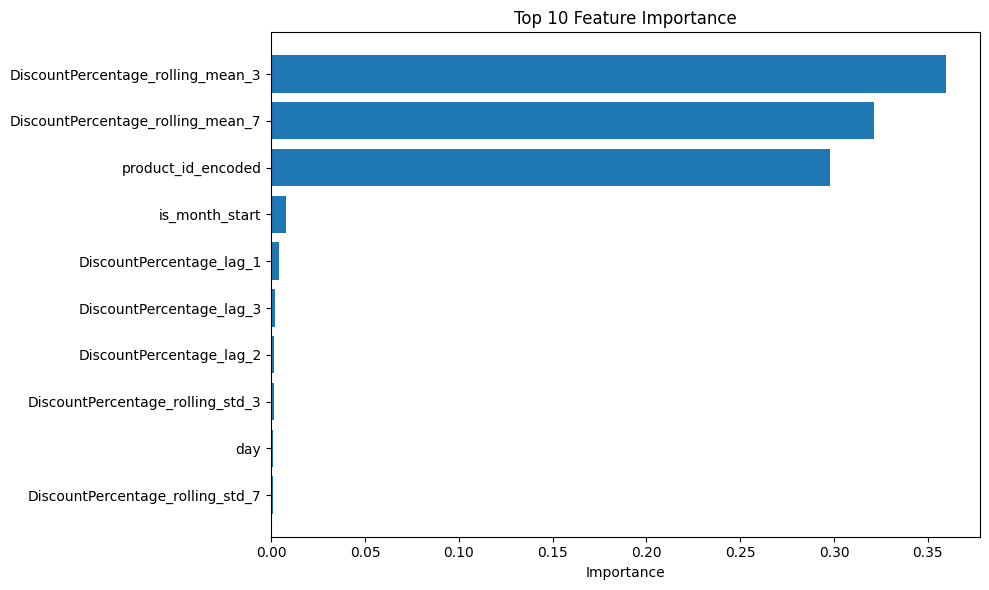

In [14]:
# Feature importance
import matplotlib.pyplot as plt

importance = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\\n📊 Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'].head(10), feature_importance_df['importance'].head(10))
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Save Model Artifacts

In [15]:
# Save model and artifacts
import pickle
import json

# Save XGBoost model
model_filename = 'xgboost_model_real_data.json'
model.save_model(model_filename)
print(f"✅ Model saved to {model_filename}")

# Save label encoder (product_id)
encoders = {'product_id': le_product}
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)
print("✅ Label encoders saved to label_encoders.pkl")

# Save feature columns
with open('feature_columns.json', 'w') as f:
    json.dump(feature_cols, f)
print("✅ Feature columns saved to feature_columns.json")

# Save model metadata
metadata = {
    'train_r2': float(train_r2),
    'test_r2': float(test_r2),
    'test_rmse': float(test_rmse),
    'test_mae': float(test_mae),
    'n_samples': len(df_clean),
    'n_products': int(df_clean['product_id'].nunique()),
    'n_features': len(feature_cols),
    'date_range': {
        'start': str(df_clean['Date'].min()),
        'end': str(df_clean['Date'].max())
    },
    'trained_on': str(datetime.now())
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Model metadata saved to model_metadata.json")

print("\\n🎉 All artifacts saved successfully!")

✅ Model saved to xgboost_model_real_data.json
✅ Label encoders saved to label_encoders.pkl
✅ Feature columns saved to feature_columns.json
✅ Model metadata saved to model_metadata.json
\n🎉 All artifacts saved successfully!
